In [1]:
from src import preprocessor
from src import full_model
from src import generate
from src import evaluate
from src import TimeSeriesData
from src import plot_model_errors

import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# **Initial Performance - Untrained Qwen**

- I will now explain my moduluar pipeline, which are all functions and classes stored in `src`
- **All of these functions automatically track the flops required**

---
### `Preprocessor` — Scaling & Encoding Time Series from HDF5

This function:
- loads simulated Lotka-Volterra predator-prey data from an HDF5 file
- scales it to be 90% 0-10 
- encodes the result as semicolon-delimited strings for tokenisation by a Qwen model.

---

### `Decoder` — Convert Encoded String Back to Time Series Arrays

This is used post-generation to recover numerical time series from Qwens string outputs.

This function:
- reverses the tokenisation-friendly encoding, decoding a semicolon-separated string (e.g., "1.2,0.5; 1.3,0.6; ...") back into two NumPy arrays:
        - One for prey population values
        - One for predator population values

---

### `TimeSeriesData` — Tokenised Chunked Dataset for Transformers

This PyTorch Dataset: 
- processes a list of time-series string sequences into string format. 
- tokenises the sequences using a provided tokenizer (e.g. the one loaded from Huggiong face qwen)
- chunks them into fixed-length segments with a configurable stride, and pads shorter sequences. 
- this prepares data efficiently for transformer-based models.
- it can be loaded directly into dataloader

---

### `Full_model` — Load and LoRA-Inject a Pretrained Transformer

This function:
- loads a pretrained Qwen transformer model 
- optionally injects Low-Rank Adaptation (LoRA) into its query (q_proj) and value (v_proj) attention layers.
    - If lora_rank = 0: returns the unmodified base model
    - If lora_rank > 0: replaces Q/V projections with LoRA-augmented layers for parameter-efficient fine-tuning

---

### `EarlyStopping` — Prevent Overfitting with Adaptive Termination

This utility class:
-  monitors the validation metric (e.g., loss) 
-  stops training early if no improvement is observed after a fixed number of evaluations (patience).
    - used in training to reduce overfitting and save compute with our flops budget
	- trigger: No improvement for patience consecutive validations

---

### `Train` — LoRA Transformer Training with Validation, Logging, and Early Stopping

This function:
- trains a LoRA-injected transformer model with mini-batch gradient descent using Adam
- periodic validation every `eval_freq` steps
- early stopping via `EarlyStopping` class based on validation loss
- FLOPs tracking for both training and evaluation
- optional Weights & Biases logging for metrics and hyperparameters
- validation on a subset of the validation set for faster evaluation during training
- final full validation after training completion
- saving training results to a JSON file, including loss, FLOPs, and early stopping information
- tracks training and validation losses and steps
- returns the trained model, loss trackers, step trackers, final validation loss, and FLOPs counts

--- 

### `Evaluate` — Validation Loss and FLOPs Estimation for LoRA Models

This function:
- evaluates a LoRA-injected transformer model with average cross-entropy loss calculation over a validation set
- has optional subset evaluation for speed-up during sweeps
- model set to .eval() mode with dropout and noise disabled
- FLOPs tracking for total evaluation compute

---

### `Generate` — Autoregressive Sequence Prediction from Context Using LoRA Model

This function
- generates future time series tokens from a context window
- split the input sequence at a defined inference_split point
- generate using greedy or stochastic decoding (via randomness flag)
- decode predicted text into prey/predator trajectories
	•	estimate FLOPs consumed during autoregressive inference
	•	optionally visualize predicted vs. ground-truth populations with plot=True

---

### `Hyperparameter_run` — Hyperparameter Training Run with LoRA

This function
-  performs a training run of a LoRA-adapted transformer model using specified hyperparameters.
- handles model loading, dataset preparation, training, and optional logging and saving.

--- 

### `Hyperparam_wandb` — Run Sweep Trial with LoRA and W&B Integration

This function:
- acts as the entry point for hyperparameter sweep runs using Weights & Biases’ `wandb.agent()`
- automatically:
    - loads a LoRA-injected Qwen transformer via `full_model`
    - prepares the tokenised dataset via `preprocessor` and `TimeSeriesData`
    - launches training with `train(...)`, passing in sweep-defined hyperparameters from `wandb.config`
- handles training, validation, FLOPs tracking, and logging entirely within the Weights & Biases sweep environment.



# Two Methods of Evaluating: Untrained Qwen Model

In the following, I evaluate the performance of the untrained Qwen model on time series data using two complementary methods.

## **1. Cross Entropy Loss on the Test Set**

- I first evaluate the model using its internal loss metric—cross entropy loss—
- This measures how well the model predicts the next token at each time step.
- The model outputs a probability distribution (logits) over the vocabulary at each time step.
- The cross entropy loss quantifies the difference between this distribution and the true next token in the sequence.
- This is the same loss function used during training, and it gives us a measure of how well the model is fitting the data in a token-wise sense.

    - **Limitation:** While a useful measure of learning progress, it does not directly represent how well the model will generate meaningful future values, in the context of time series forecasting.

## **2. Mean Squared Error / Mean Absolute Error/ Mean Absolute Percentage Error via Autoregressive Generation**

- A more accurate way of respresenting error over time

- To complement the above I perform autoregressive generation:
    - Starting from a given context window of past tokens, the model predicts the next token.
    - This predicted token is then fed back in as input, and the process repeats for a set number of steps.
    - The generated sequence is then compared to the ground truth future sequence using Mean Squared Error (MSE), Mean Absolute Error (MAE) or Mean Absolute Percentage Error (MAPE).

- This approach has the advantage of evaluating the model in a realistic forecasting scenario:
    - It reflects how errors accumulate over time.
    - It gives a direct and intuitive measure of the model’s performance on predicting actual values rather than token probabilities.

In [ ]:
# Load the model with no lora
model, tokeniser, device = full_model(lora_rank=0)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Returned the base Qwen model without modification (rank = 0).
Model loaded on mps


In [ ]:
# Load the training, validation and test sets
train_set, validation_set, test_set = preprocessor('lotka_volterra_data.h5', percentile= 90, decimal_places=3,  train_fraction =0.8, validation_fraction= 0.1 , shuffle = False, tokeniser_model = tokeniser)

INFO - File loaded successfully. Trajectories shape: (1000, 100, 2), Time points shape: (100,)
INFO - Scaling data by alpha=0.25283724069595337, ensuring 90% of values fit within the model's expected range.
INFO - Data scaled to 3 decimal places
INFO - Splitting the data into training, validation, and test sets with fractions: 0.8, 0.1, 0.09999999999999995
INFO - An example of the data encoding is shown below:
Before Encoding - First 5 Prey Data: ['3.757', '2.929', '2.698', '2.835', '3.261']
Before Encoding - First 5 Predator Data: ['4.116', '3.083', '2.232', '1.612', '1.188']
After Encoding to String - First 5 Entries: 3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.612;3.261,1.188
After Encoding to Tokenised: [18, 13, 22, 20, 22, 11, 19, 13, 16, 16, 21, 26, 17, 13, 24, 17, 24, 11, 18, 13, 15, 23, 18, 26, 17, 13, 21, 24, 23, 11, 17, 13, 17, 18, 17, 26, 17, 13, 23, 18, 20, 11, 16, 13, 21, 16, 17, 26, 18, 13, 17, 21, 16, 11, 16, 13, 16, 23, 23]


## A simple few examples of how it preforms (test set examples are given in Notebook 7 before and after)
### These are not from the shuffeled data but simply used as examples
- Data is shuffled during analysis

Generating 294.0 tokens from a context of 976 tokens
Using a deterministic (greedy) sampling technique, randomness is disabled


/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/venvs/M2_CW_Venv_3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/venvs/M2_CW_Venv_3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/venvs/M2_CW_Venv_3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based genera

Flops associated with generation: 407273199502470


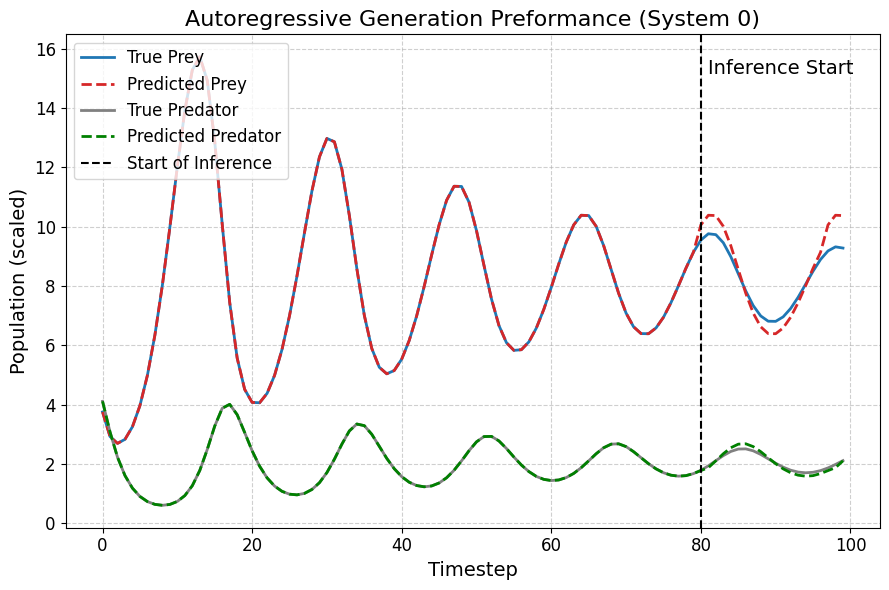

In [ ]:
prey_original_1, predator_original_1, prey_generated_1, predator_generated_1, total_flops_1 = generate(model, tokeniser, train_set, sequence_no = 0, inference_split = 0.8, plot = True, randomness = False, print_output = True)

Generating 300.0 tokens from a context of 996 tokens
Using a deterministic (greedy) sampling technique, randomness is disabled
Flops associated with generation: 424815993918900


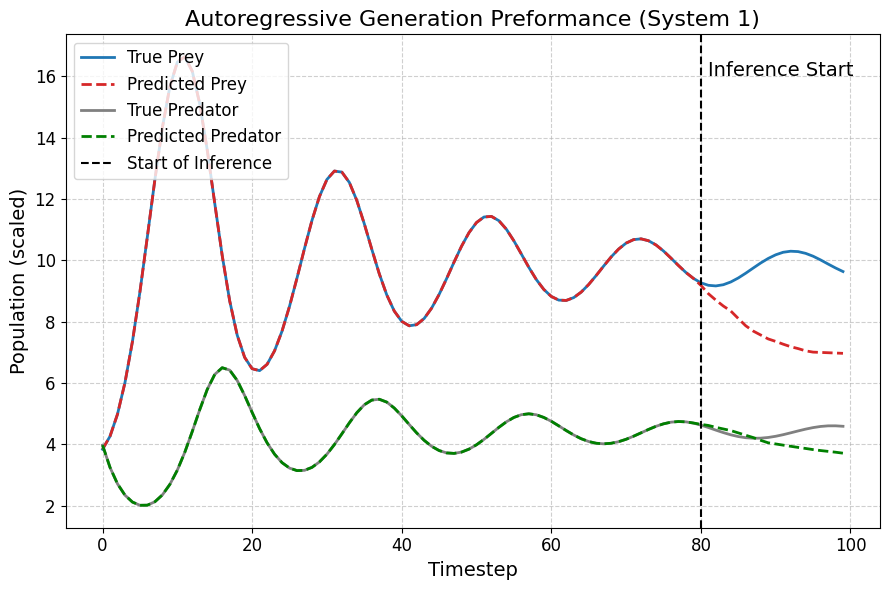

In [ ]:
prey_original_2, predator_original_2, prey_generated_2, predator_generated_2, total_flops_2 = generate(model, tokeniser, train_set, sequence_no = 1, inference_split = 0.8, plot = True, randomness = False, print_output = True)

Generating 733.1999999999999 tokens from a context of 610 tokens
Using a deterministic (greedy) sampling technique, randomness is disabled


/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/venvs/M2_CW_Venv_3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/venvs/M2_CW_Venv_3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/venvs/M2_CW_Venv_3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based genera

Flops associated with generation: 877676215739622


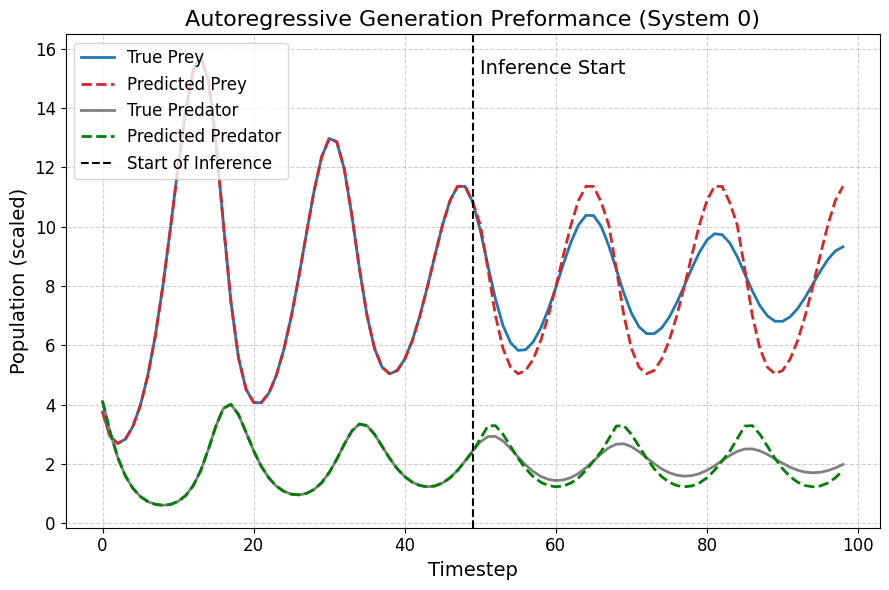

In [ ]:
prey_original_3, predator_original_3, prey_generated_3, predator_generated_3, total_flops_3 = generate(model, tokeniser, train_set, sequence_no = 0, inference_split = 0.5, plot = True, randomness = False, print_output = True)

In [ ]:
prey_original_4, predator_original_4, prey_generated_4, predator_generated_4, total_flops_4 = generate(model, tokeniser, train_set, sequence_no = 1, inference_split = 0.5, plot = True, randomness = True, print_output = True)

# 1. Cross Entropy Loss on Full Test Set
### Shuffeling has now been turned on
- Using the evaluate function previously discussed

In [ ]:
# Load the training, validation and test sets
train_set, validation_set, test_set = preprocessor('lotka_volterra_data.h5', percentile= 90, decimal_places=3,  train_fraction =0.8, validation_fraction= 0.1 , shuffle = True, tokeniser_model = tokeniser)

In [ ]:
test_dataset = TimeSeriesData(test_set, tokeniser, max_length=762, stride=762)

In [ ]:
Intial_loss, flop_cost = evaluate(model, test_dataset, accelerator=None, lora_ranks=0, subset = None, print_summary=True)
print(f'Initial loss: {Intial_loss}')

Total FLOPs for evaluation: 1.8103e+14
Total FLOPs from LoRA adaptation: 0
Percentage of Total FLOPs Budget:   0.18103 %
Initial loss: 4.779372409085433


# 2. MSE/ MAE/ MAPE for the Test Set
- This analysis gives the MSE, MAE and MAPE for over a give number of random tests as a function of time step.

/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/src/analysis.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


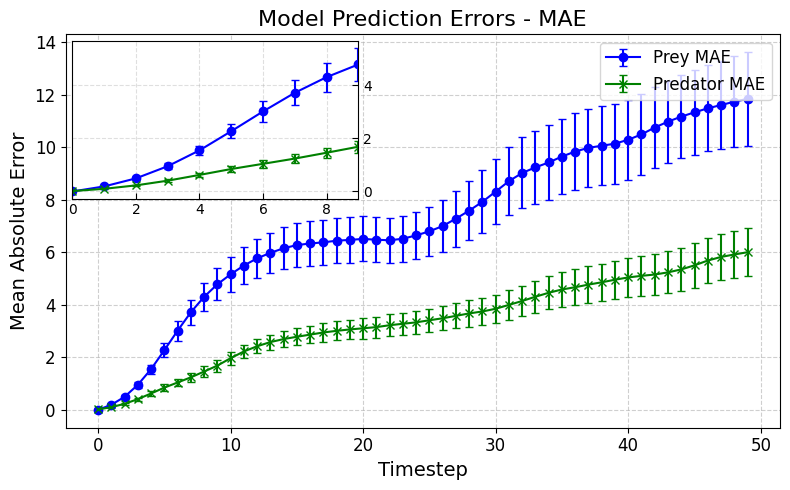

/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/src/analysis.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


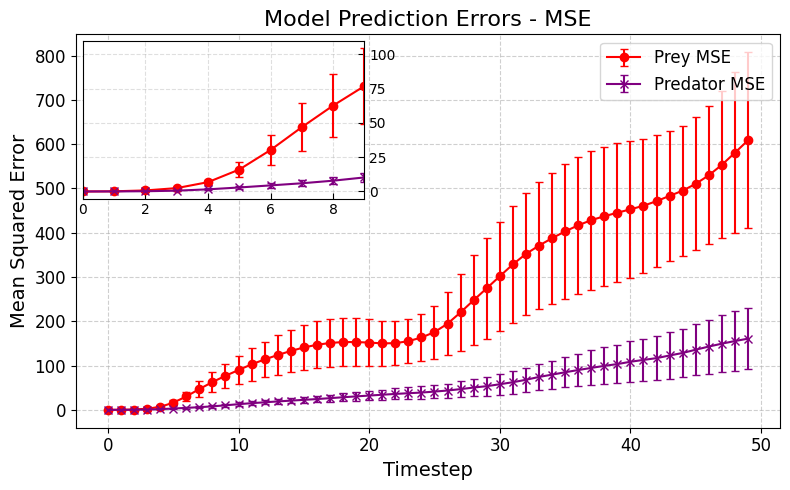

/Users/jacobtutt/Desktop/MPhil_DIS/M2/Coursework_M2/src/analysis.py:228: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


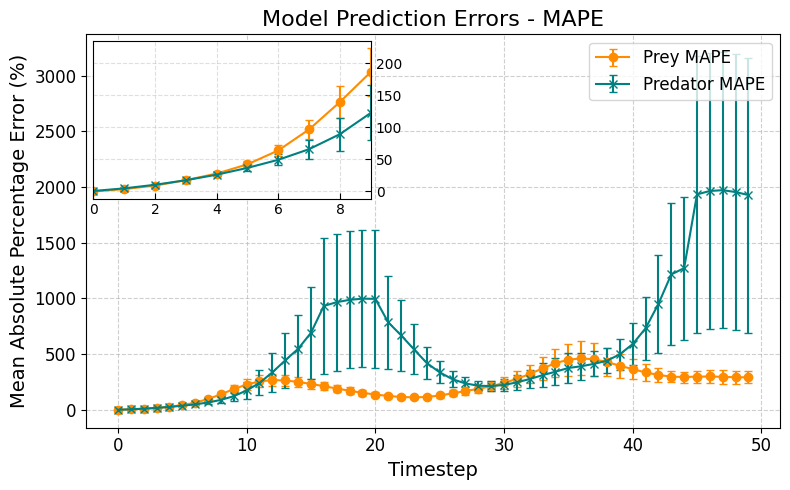

,Timestep,MAE Prey ± SE,MAE Predator ± SE,MSE Prey ± SE,MSE Predator ± SE,MAPE Prey ± SE (%),MAPE Predator ± SE (%)
0,0,0.001 ± 0.001,0.016 ± 0.003,0.000 ± 0.000,0.002 ± 0.001,0.02 ± 0.01,0.76 ± 0.16
1,1,0.192 ± 0.025,0.101 ± 0.012,0.133 ± 0.071,0.033 ± 0.012,3.72 ± 0.45,4.86 ± 0.40
2,2,0.495 ± 0.060,0.230 ± 0.029,0.769 ± 0.274,0.182 ± 0.080,9.15 ± 1.15,10.45 ± 0.84
3,3,0.952 ± 0.103,0.408 ± 0.053,2.462 ± 0.583,0.586 ± 0.226,17.67 ± 2.40,17.51 ± 1.40
4,4,1.549 ± 0.173,0.624 ± 0.089,6.808 ± 1.916,1.570 ± 0.635,27.87 ± 3.02,26.17 ± 2.65
5,5,2.270 ± 0.271,0.846 ± 0.122,16.022 ± 5.187,2.926 ± 1.153,42.29 ± 4.80,36.75 ± 4.86
6,6,3.013 ± 0.379,1.042 ± 0.151,30.287 ± 10.827,4.444 ± 1.679,63.96 ± 8.56,49.36 ± 8.72
7,7,3.716 ± 0.473,1.239 ± 0.173,46.959 ± 17.325,5.987 ± 2.149,96.70 ± 15.00,65.90 ± 15.03
8,8,4.304 ± 0.546,1.459 ± 0.197,62.706 ± 22.805,7.880 ± 2.672,139.42 ± 24.67,89.32 ± 25.74
9,9,4.782 ± 0.604,1.685 ± 0.224,76.925 ± 27.419,10.257 ± 3.268,186.08 ± 36.68,122.37 ± 42.94


In [2]:
with open("results/Evaluation/InitialQwenAnalysis.json", "r") as f:
    results = json.load(f)

# Load data from tables 
prey_original = np.array(results["prey_original"])
prey_generated = np.array(results["prey_generated"])
predator_original = np.array(results["predator_original"])
predator_generated = np.array(results["predator_generated"])


plot_model_errors(prey_original, prey_generated, predator_original, predator_generated, title_prefix="Model Prediction Errors")